# Calculate price-equilibrium using simulations

In [4]:
import sys, numpy as np, scipy
from sympy import symbols
from typing import Callable
from log_progress import log_progress
np.random.seed(None)

import matplotlib.pyplot as plt, mpld3
%matplotlib inline
mpld3.enable_notebook()  # to zoom and move in plots

resetSize,r,zmin,zmax,beta,D,L,Supply = symbols('a r  z_{\min} z_{\max} \\beta \\Delta \\ell \\tau', positive=True,finite=True,real=True)
params = {
    L: 10,           # total transfers per pair per day.
    D: 6,            # delta transfers per day (Alice-to-Bob minus Bob-to-Alice) in the asymmetric case.
    beta: 0.01,      # value / transfer-size
    r: 4/100/365,    # interest rate per day
    resetSize: 1.1,  # records per reset tx
    Supply: 288000,  # records per day
    zmin: 0.001,     # min transfer size in bitcoins (for power law distribution)
    zmax: 1,         # max transfer size in bitcoins (for uniform distribution)
}
# NOTE: These are the same params used in the symbolic comnputations (market-equilibrium notebook).

In [6]:
if "Simulation" in sys.modules: del sys.modules["Simulation"]
from Simulation import *
sim = PowerlawSymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/powerlaw-2.5-10million-symmetric-1000days") 
sim.setPower(2.5)
# You can also try the following options:
#sim = PowerlawAsymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/powerlaw-asymmetric-1000days")
#sim = UniformSymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/uniform-symmetric-1000days")
#sim = UniformAsymmetricSimulation(params, numOfDays=1000, filenamePrefix="interpolation-tables/uniform-asymmetric-1000days")

sim.loadTables()

Simulation.py version 1.0
<class 'FileNotFoundError'>


## Channel operation and definitions
We consider a channel with a total capacity $w$. Since the transfer-rate from Alice to Bob is the same as from Bob to Alice, we assume that the channel is initialized symmetrically - each agent contributes $w/2$. The "channel state" is the balance of Alice in the channel; therefore the initial state is $w/2$.

Whenever a transfer has to be made, we first check whether it can be done in the current channel state (i.e, whether the agent making the transfer has a sufficiently high balance). If the transfer can be done in the channel, then it is done and the channel state is updated. Otherwise, we check whether it is worthwhile to do the transfer in the blockchain: if the transfer value (which is $\beta$ times its size) is larger than the current fee, then the transfer is done on the blockchain; otherwise, it is not done at all.

In the initial state ($w/2$), the chances of channel failure are relatively small; as the channel drifts away from this initial state towards one of its endpoints, the chances of channel failure increase. Therefore, at some states it may be worthwhile to do a *channel reset* and return the channel to its initial state. We assume that there is some constant $R$ such that, whenever the state after a channel transfer is smaller than $R$ or larger than $w-R$, it is reset to $w/2$. We call $R$ the *reset radius*. 

## Finding the optimal reset-radius
The first step in analyzing the channel performance is finding the optimal reset radius. The following plots illustrate the channel performance as a function of the reset radius, for a capacity of $w=10$.

The first plot shows the number of *blockchain hits* --- the number of blockchain records required for a typical sequence of transfers (this is the sum of the records used for out-of-channel transfers and the records used for reset transactions). The number of blockchain hits is minimized when the reset radius is about 0.5.

The second plot shows the net utility of the agents, which is their value from making the transfers ($\beta$ times the transfer sizes) minus the fee paid for blockchain hits. The utility is maximized at approximately the same point - 0.5. 

The third plot shows how many transfers are done in the blockchain and how many are done in the channel.

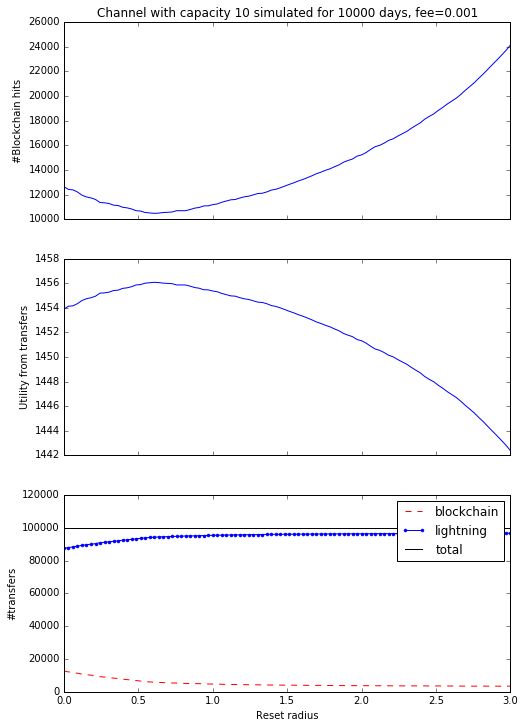

In [7]:
sim.plotBlockchainHitsVsResetRadiuses(
    numOfDays=10000, 
    channelCapacity=10, 
    resetRadiuses=np.linspace(0,3,100), 
    blockchainFee=.001)

The following plots are the same as above with a higher blockchain fee --- $0.1$. 

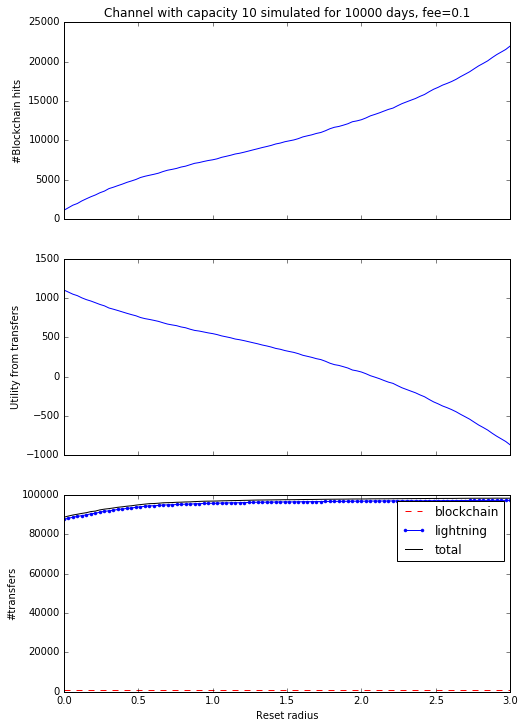

In [5]:
sim.plotBlockchainHitsVsResetRadiuses(
    numOfDays=10000, 
    channelCapacity=10, 
    resetRadiuses=np.linspace(0,3,100), 
    blockchainFee=0.1)

We now calculate the optimal reset radius. Naturally, the optimum depends on the capacity $w$ and on the blockchain fee. Below, for simplicity we calculate and plot the optimal reset radius only as a function of $w$, for a fixed fee of $0.001$. We make 50 experiments, each of which simulates transfers over 1000 days. We show the average optimal radius, as well as a linear regression line; it shows that the optimal reset radius is approximately 7 percent of the channel capacity.

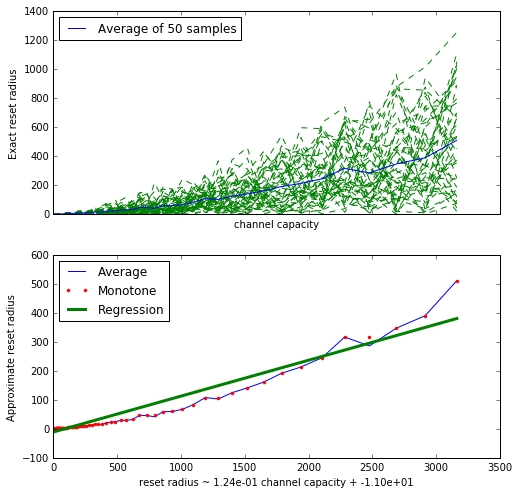

In [18]:
# sampleCapacities = np.concatenate((np.linspace(1,30, 30),np.linspace(30,1000, 98)))
sampleCapacities = np.logspace(0, 3.5, 100, base=10)
sim.calculateOptimalResetRadiusTable(
    numOfDays=1000, 
    channelCapacities=sampleCapacities, 
    blockchainFee=0.001,
    numOfSamples=50,
    recreateAllSamples=False,   # False means to reuse the existing samples and calculate only numOfSamples-numOfExistingSamples new samples.
    )
sim.saveTables()
sim.plotOptimalResetRadiusTable()

## Finding the optimal channel capacity
From now on, we assume that each channel with capacity $w$ is operated with the optimal reset-radius for this capacity, using the linear regression formula calculated in the previous subsection. Our next goal is to calculate the optimal channel capacity, given the blockchain fee (and the fixed interest rate $r$). 

Below we show some plots of the channel performance as a function of the channel capacity, for different blockchain fees. As $w$ increases, the *blockchain cost* (the cost from blockchain transfers and reset transactions) decreases, but the *economic cost* (the cost from interest) increases. The optimal utility is attained at a capacity in which these two costs are approximately equal.

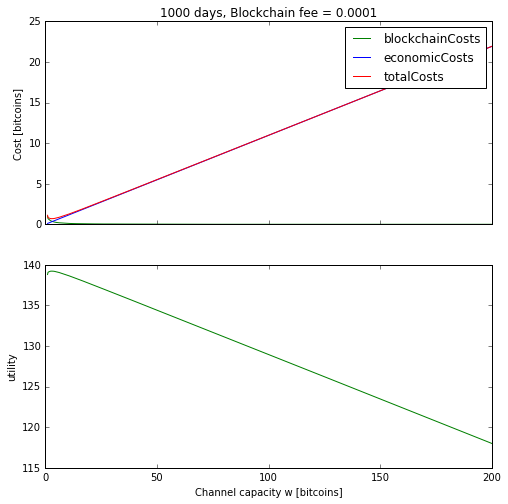

In [8]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.0001, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

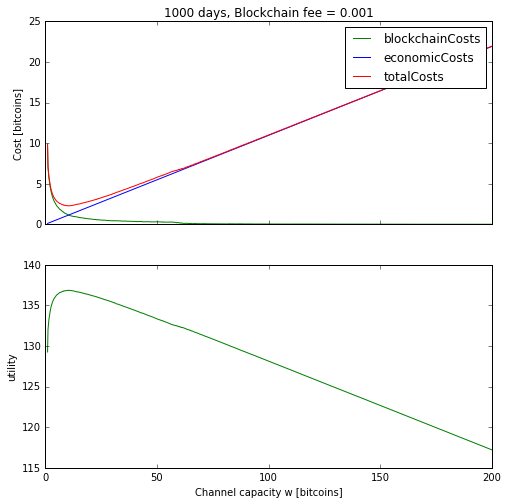

In [11]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.001, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

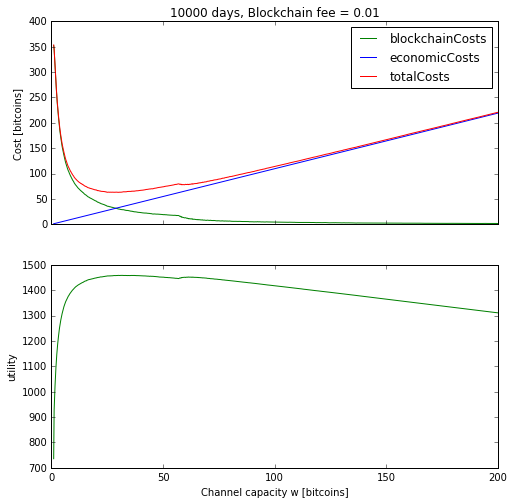

In [12]:
sim.plotCostsVsChannelCapacity(
    numOfDays=10000, 
    blockchainFee=0.01, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

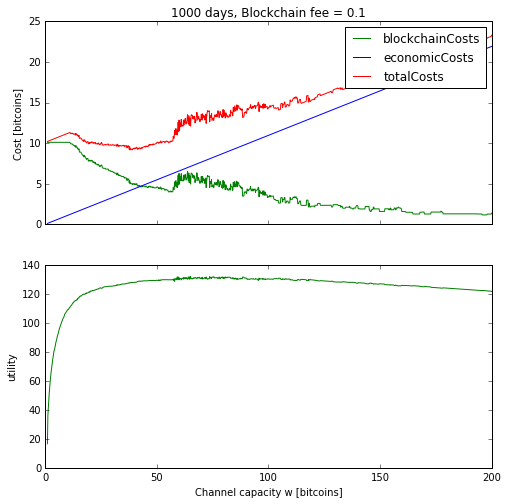

In [13]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=0.1, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

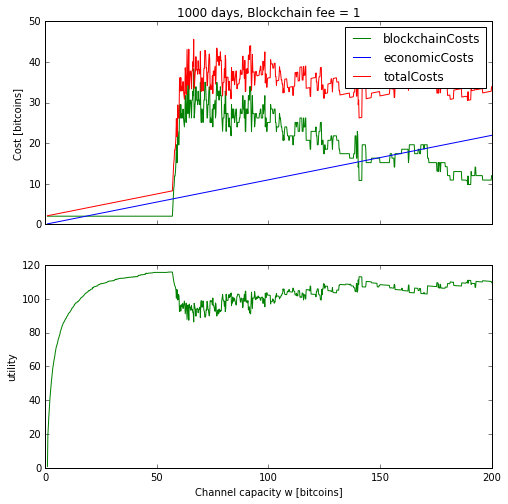

In [14]:
sim.plotCostsVsChannelCapacity(
    numOfDays=1000, 
    blockchainFee=1, 
    channelCapacities = np.linspace(1*params[zmax],200*params[zmax],1000))

We now calculate the optimal channel capacity as a function of the blockchain fee. We make 50 experiments, each of which simulates transfers over 1000 days. We show the average channel capacity, as well as a log-log regression line; it shows that the optimal channel capacity is approximately a constant times $\sqrt{\phi}$.

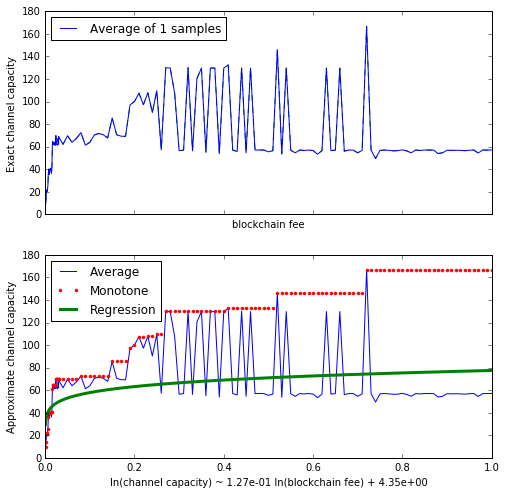

In [10]:
sampleBlockchainFees = np.concatenate((np.linspace(1,30, 30),np.linspace(30,1000, 98)))/1000
#sampleBlockchainFees = np.logspace(-3,1,100,base=10)  
sim.calculateOptimalChannelCapacityTable(
    numOfDays=1000, 
    blockchainFees=sampleBlockchainFees,
    numOfSamples=1,
    recreateAllSamples=True,  # False means to reuse the existing samples and calculate only numOfSamples-numOfExistingSamples new samples.
    )
sim.saveTables()
sim.plotOptimalChannelCapacityTable()

## Demand curves
From now on, we assume that each channel is funded with the optimal $w$ given the blockchain fee, and operated with the optimal reset-radius given that $w$.

We calculate the curve of demand for blockchain records: for each value of $\phi$ (the blockchain fee), we calculate the number of records required to do the randomly-drawn transfers. This calculation is done in two steps: first, we calculate the total cost for doing all these transfers in a lightning channel (the blockchain cost plus the economic cost). We assume that this cost should be covered by putting a fee on each lightning transaction. The lightning fee is proportional to the transfer size, and the value of a transfer is also proportional to the transfer size. Therefore, if the total cost is smaller than the total value of all transfers, then all transfers will be done in the lightning channel. If the total cost is larger than the total value, then no transfers will be done in the lightning channel. In the latter case, the users will do only the transfers whose value is above the blockchain fee.

Below we show some plots of the daily demand for blockchain records (per pair of users) as a function of the blockchain fee. Log-log regression shows that the demand is approximately a constant times $1/\sqrt{\phi}$.

In [ ]:
sim.plotDailyDemandVsBlockchainFee(
    numOfDays=10000, 
    blockchainFees=sampleBlockchainFees, 
    figsize=(10,5))

Below we show the demand-curve when there is no lightning network. 
Here, the demand is initially much higher, but it also drops much faster with the fee - the demand is approximately a constant times $1/\phi$.

In [ ]:
sim.plotDailyDemandVsBlockchainFee(
    numOfDays=1000, 
    blockchainFees=sampleBlockchainFees, 
    figsize=(10,5), 
    withLightning=False)

## Equilibrium fee
Below we calcualte the blockchain fee as a function of the number of users in the system. The blockchain fee grows super-linearly with the number of users. There is a very good fit with a polynom of degree 2, which shows that the blockchain fee grows like $\Theta(n^2)$, where $n$ is the number of users.

In [ ]:
#numsOfUsers = np.concatenate((np.linspace(1e5, 10e5, 40), np.linspace(10e5, 100e5, 40), np.linspace(100e5, 1000e5, 40)))
numsOfUsers = np.logspace(5, 8, 100, base=10)  # from 10^5 to 10^8

supply = params[Supply]
sim.calculateEquilibriumBlockchainFeeTable(
    numOfDays=1000, 
    numsOfUsers=numsOfUsers, 
    supply=supply, 
    numOfSamples=50, 
    recreateAllSamples=False)
sim.saveTables()
sim.plotEquilibriumBlockchainFeeTable(supply)

Below we do the same calculation when the supply is multiplied by 2 --- simulating the effect of doubling the block size. The graph is similar but the equilibrium fee is smaller by a factor of 3-4.

In [ ]:
supply = params[Supply]*2
sim.calculateEquilibriumBlockchainFeeTable(
    numOfDays=1000, 
    numsOfUsers=numsOfUsers, 
    supply=supply, 
    numOfSamples=50, 
    recreateAllSamples=False)
sim.saveTables()
sim.plotEquilibriumBlockchainFeeTable(supply)

Below we repeat these calculations for a network without lightning. Apparently, the fee increases linearly with the number of users.

In [ ]:
supply = params[Supply]+1   # add 1 to save it in a different table than with lightning (a hack)
sim.calculateEquilibriumBlockchainFeeTable(
    numOfDays=1000, 
    numsOfUsers=numsOfUsers, 
    supply=supply, 
    numOfSamples=50, 
    recreateAllSamples=False,
    withLightning=False)
sim.saveTables()
sim.plotEquilibriumBlockchainFeeTable(supply)

In [ ]:
supply = 2*params[Supply]+1   # add 1 to save it in a different table than with lightning (a hack)
sim.calculateEquilibriumBlockchainFeeTable(
    numOfDays=1000, 
    numsOfUsers=numsOfUsers, 
    supply=supply, 
    numOfSamples=50, 
    recreateAllSamples=False,
    withLightning=False)
sim.saveTables()
sim.plotEquilibriumBlockchainFeeTable(supply)

## Overall network performance
The following plots show the network performance (including blockchain fees, miners revenue and more) as a function of the number of users. As the number of users grows, the equilibrium fee grows super-linearly and with it, the miners' revenue. The utility per user decreases.

The left plots are for the current supply of 288000; the right plots are for a double supply, representing a doubling in the block size. Up to 10 million users, the blockchain fee is smaller by factor 4, and the miners' revenue is smaller by factor 2, and the utility per user is almost the same. Up to 100 million users, the blockchain fee is smaller by factor 3, the miners' revenue is smaller by factor 1.5, and the utility per user is higher by factor 1.5.

In [ ]:
sim.plotNetworkPerformanceVsNumOfUsers2(
    numOfDays=10000, 
    numsOfUsers=numsOfUsers, 
    supplies=[params[Supply],2*params[Supply]],
    figsize=(15,22))

Below we repeat the same calculations for a world without lightning.
Both the miners' revenue and the utility-per-user are much lower than with lightning; doubling the block-size has little effect.

In [ ]:
sim.plotNetworkPerformanceVsNumOfUsers2(
    numOfDays=10000, 
    numsOfUsers=numsOfUsers, 
    supplies=[params[Supply],2*params[Supply]],
    figsize=(15,22),
    withLightning=False)